In [2]:
import pandas as pd
import matplotlib.pyplot as plt

OBSI DATA

In [3]:
#Transform OBSI into column form, basic dataframe
OBSI = pd.read_excel("C:\\Quiet_Pavement_Local\\Data Summary QP Re-Analysis.xlsx", sheet_name = "ALL OBSI", header = 1).T
OBSI.rename_axis(None,axis=1, inplace = True)
OBSI.drop([0,4], axis = 1, inplace = True)
OBSI.columns = OBSI.iloc[0]
OBSI = OBSI[1:]
OBSI.reset_index(inplace = True)
OBSI.drop(["index"], axis = 1, inplace = True)
OBSI.columns.name = None
#Adds pavement type into dataframe
#Turn values into a lists if you want to add other metadata
pavement_type = {
    1: "3/8in Chip Seal",
    2: "1/4in Chip Seal",
    3: "Type II Microsurfacing",
    4: "Type III Microsurfacing",
    5: "3/8in Chip Seal",
    6: "Type III Microsurfacing",
    7: "Type II Microsurfacing",
    8: "1/4in Chip Seal"
}
OBSI["Pavement Type"]=[pavement_type[s] for s in OBSI["Site"]]

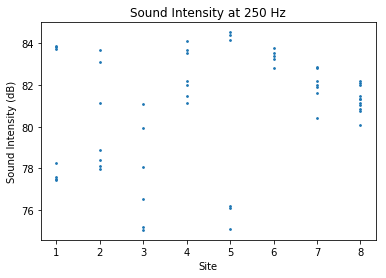

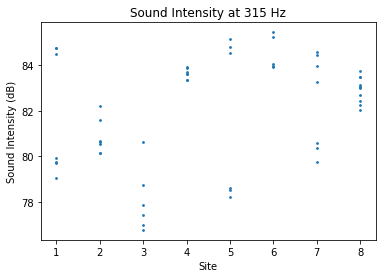

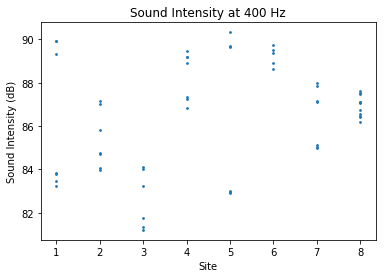

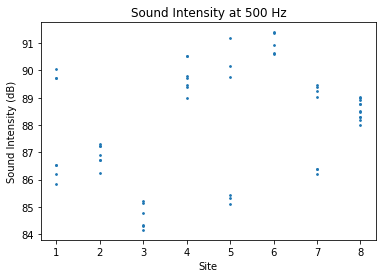

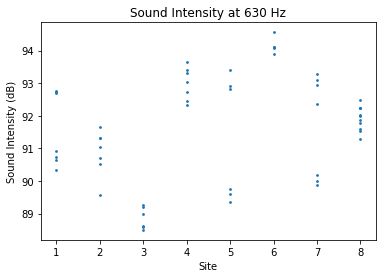

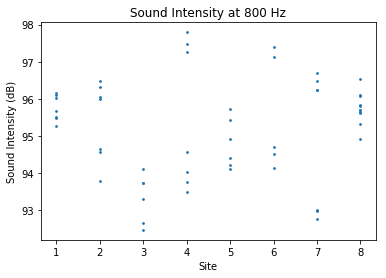

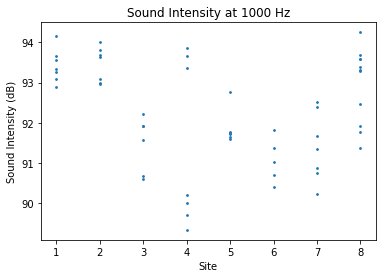

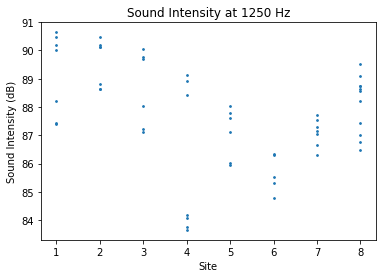

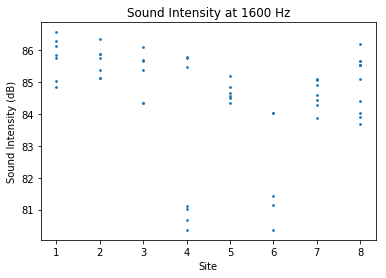

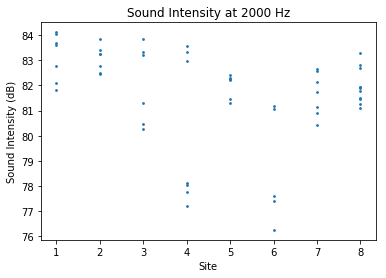

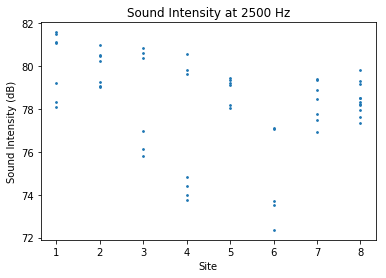

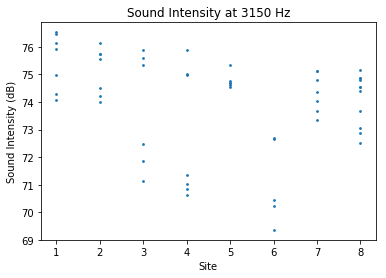

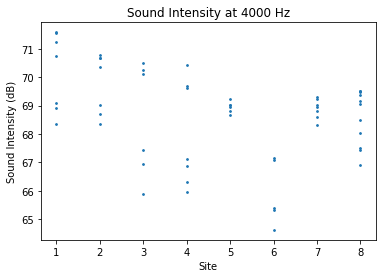

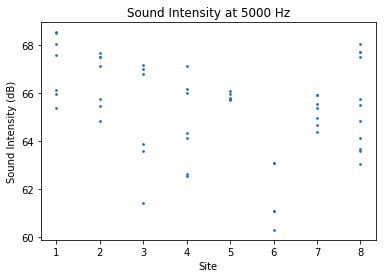

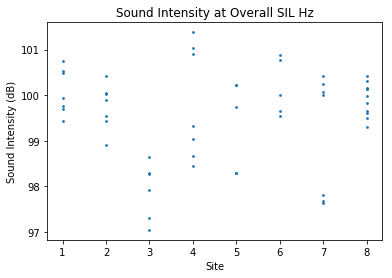

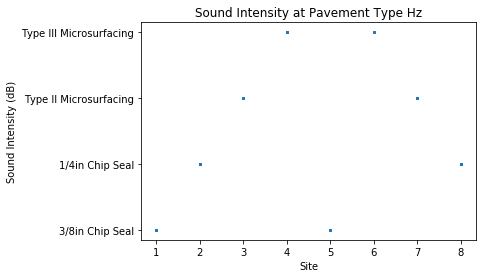

In [7]:
#Plot data by site and sound intensity. Each figure is a different frequency
for freq in OBSI.columns[3:]:
    plt.figure()
    plt.scatter(OBSI["Site"],OBSI[freq], s = 3)
    plt.title("Sound Intensity at " + str(freq) + " Hz")
    plt.xlabel("Site")
    plt.ylabel("Sound Intensity (dB)")
#     plt.ylim(58,105)

In [8]:
#Group data by year, site, pavement type, and replicates
OBSI_grouped = OBSI.set_index(["Measurement Year", "Site", "Pavement Type","Replicates"])
OBSI_grouped= OBSI_grouped.swaplevel("Pavement Type", "Site") #Use this to swap levels
OBSI_grouped.sort_index(inplace=True)
OBSI_grouped = OBSI_grouped.astype(float)

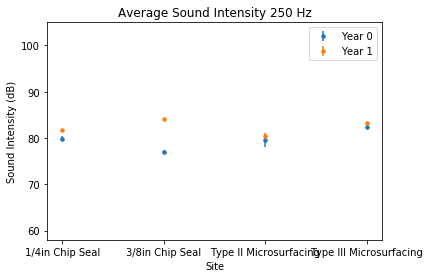

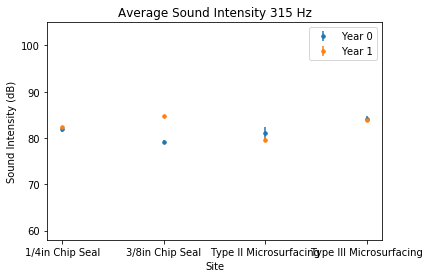

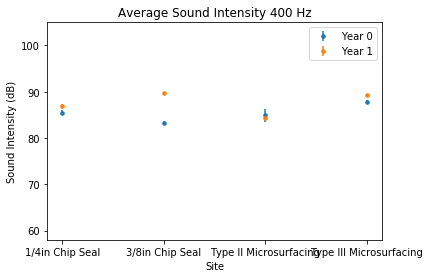

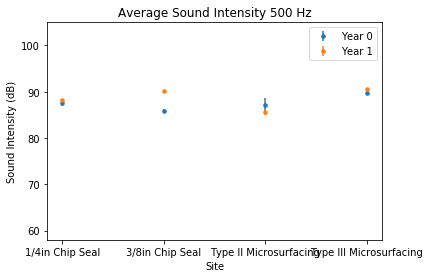

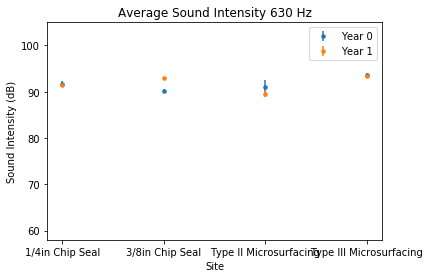

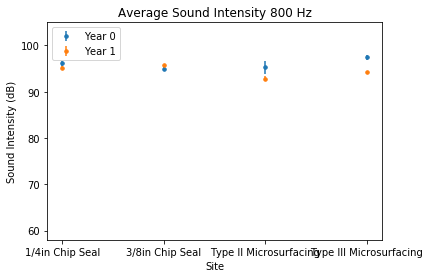

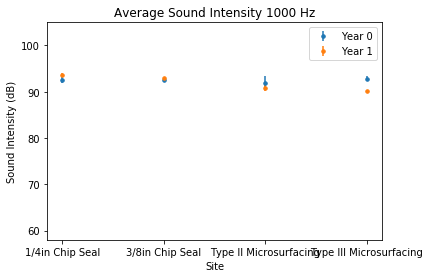

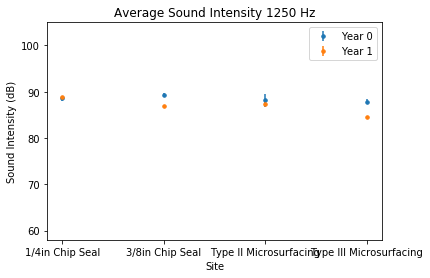

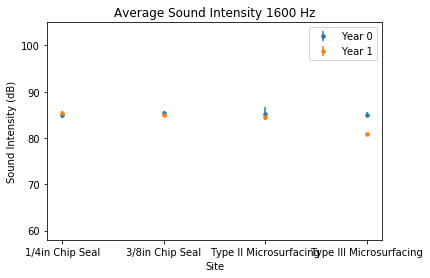

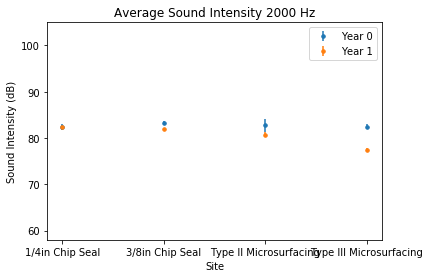

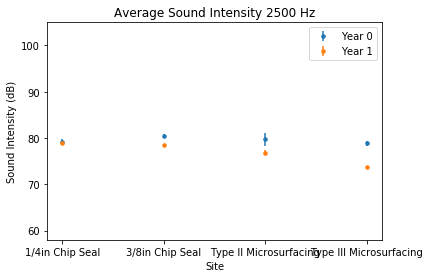

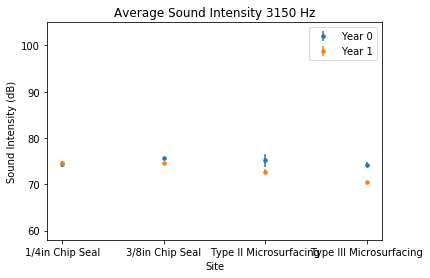

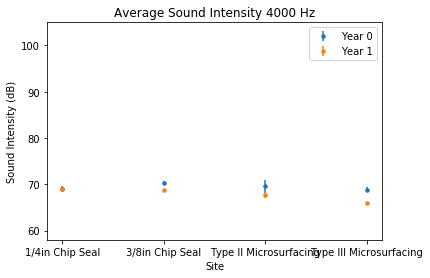

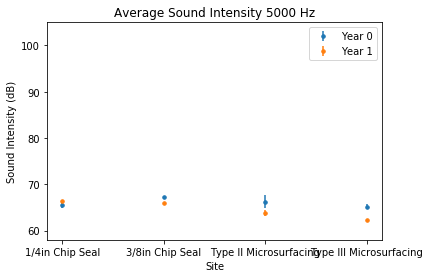

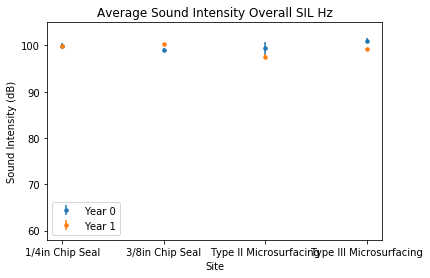

In [9]:
#Mean grouped by year and site
OBSI_mean_by_site = OBSI_grouped.groupby(level = [0,1]).mean()
OBSI_yearly_sem = OBSI_grouped.groupby(level = [0,1]).sem()
#Plot data by site and sound intensity averaged and separated by year
for freq in OBSI_mean_by_site.columns:
    plt.figure()
    plt.errorbar(OBSI_mean_by_site.loc[0].index,OBSI_mean_by_site.loc[0][freq], 
                OBSI_yearly_sem.loc[0][250], ls = "None",marker = ".", ms= 7, label = "Year 0")
    plt.errorbar(OBSI_mean_by_site.loc[1].index,OBSI_mean_by_site.loc[1][freq],
                OBSI_yearly_sem.loc[1][250], ls = "None",marker = ".", ms = 7, label = "Year 1")
    plt.legend()
    plt.xlabel("Site")
    plt.ylabel("Sound Intensity (dB)")
    plt.ylim(58,105)
    plt.title("Average Sound Intensity "+ str(freq) + " Hz")

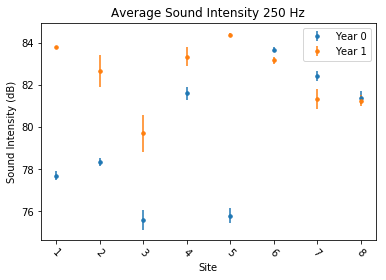

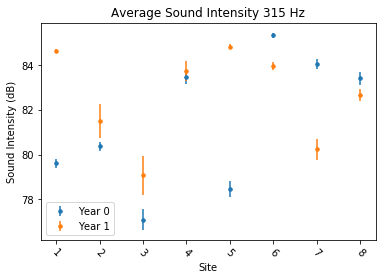

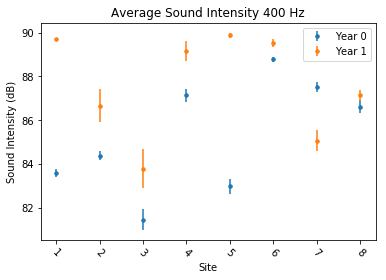

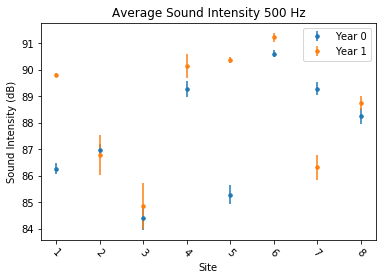

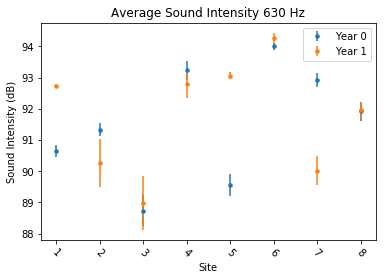

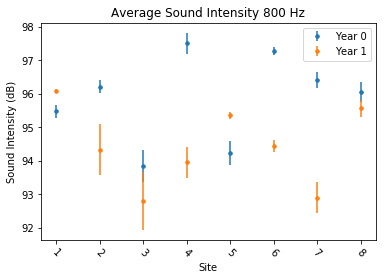

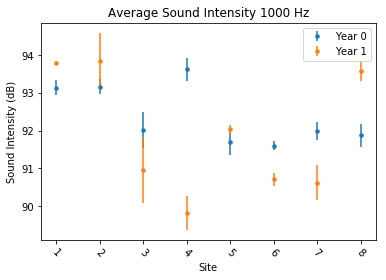

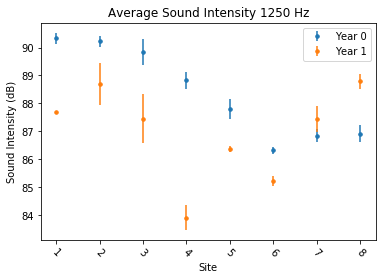

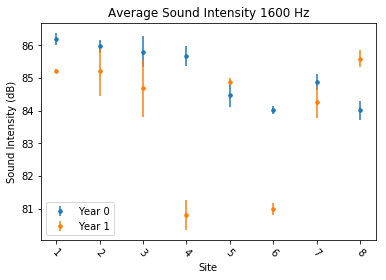

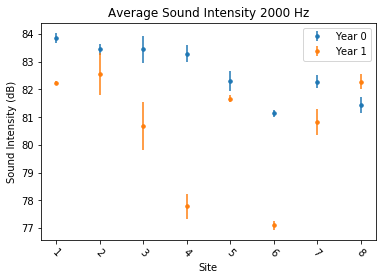

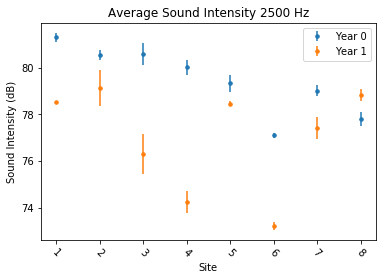

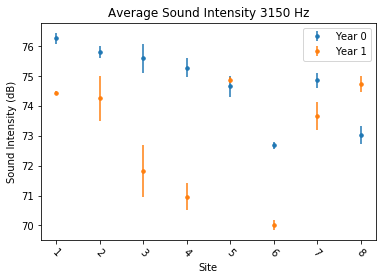

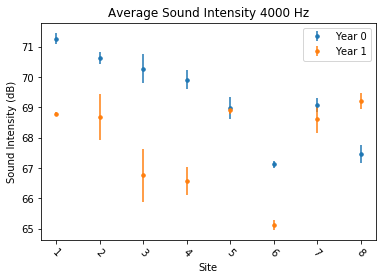

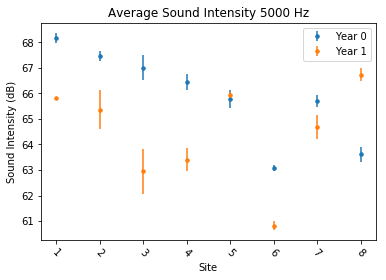

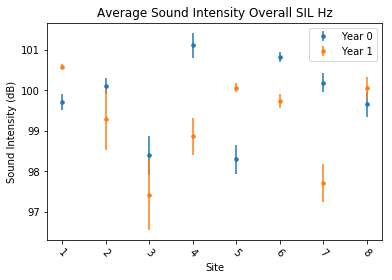

In [10]:
#Mean grouped by year and pavement type
OBSI_mean_by_pavement = OBSI_grouped.groupby(level = [0,2]).mean()
OBSI_sem_by_pavement = OBSI_grouped.groupby(level = [0,2]).sem()

for freq in OBSI_mean_by_pavement.columns:
    plt.figure()
    plt.errorbar(OBSI_mean_by_pavement.loc[0].index,OBSI_mean_by_pavement.loc[0][freq], 
                OBSI_sem_by_pavement.loc[0][250], ls = "None",marker = ".", ms= 7, label = "Year 0")
    plt.errorbar(OBSI_mean_by_pavement.loc[1].index,OBSI_mean_by_pavement.loc[1][freq],
                OBSI_sem_by_pavement.loc[1][250], ls = "None",marker = ".", ms = 7, label = "Year 1")
    plt.legend()
    plt.xlabel("Site")
    plt.ylabel("Sound Intensity (dB)")
    plt.xticks(rotation=-45)
#     plt.ylim(58,105)
    plt.title("Average Sound Intensity "+ str(freq) + " Hz")

In [12]:
#Count how many datapoints are in each grouping
OBSI_counts_by_site =OBSI_grouped.groupby(level = [0,1]).count()
OBSI_counts_by_pavement =OBSI_grouped.groupby(level = [0,2]).count()
OBSI_counts_by_pavement, OBSI_counts_by_site

(                       250  315  400  500  630  800  1000  1250  1600  2000  \
 Measurement Year Site                                                         
 0                1       4    4    4    4    4    4     4     4     4     4   
                  2       4    4    4    4    4    4     4     4     4     4   
                  3       3    3    3    3    3    3     3     3     3     3   
                  4       3    3    3    3    3    3     3     3     3     3   
                  5       3    3    3    3    3    3     3     3     3     3   
                  6       2    2    2    2    2    2     2     2     2     2   
                  7       4    4    4    4    4    4     4     4     4     4   
                  8       4    4    4    4    4    4     4     4     4     4   
 1                1       3    3    3    3    3    3     3     3     3     3   
                  2       3    3    3    3    3    3     3     3     3     3   
                  3       3    3    3   

In [178]:
OBSIbySite = OBSI.T
OBSIbySite.columns = ["S"+str(s)+"Y"+str(y)+"R"+str(r) for y,s,r in zip(OBSI["Measurement Year"],OBSI["Site"],OBSI["Replicates"])]
OBSIbySite = OBSIbySite[3:]
print(OBSIbySite)

                        S1Y0R1           S1Y0R2           S1Y0R3  \
250                     78.273          77.4241          77.5036   
315                    79.7431          79.9272          79.7277   
400                    83.4532          83.8309          83.8058   
500                    86.1897          86.5486           86.526   
630                    90.6283            90.74          90.9047   
800                    95.5003          95.4736          95.6579   
1000                   93.2674          93.0764          93.3365   
1250                   90.4746          90.2028          90.6352   
1600                   86.2794          86.1164          86.5537   
2000                   84.0429          83.6641          84.1068   
2500                   81.4986          81.1034          81.5768   
3150                   76.4767          76.1255          76.5212   
4000                   71.5557          71.2262          71.5751   
5000                   68.5469          68.0497 

ALL PASSBY DATA

In [56]:
#Processes allpassby data, turns two row header into one row header as a tuple
#QUESTION: WHAT IS THE DATA WITH NO HEADER ON THE FAR RIGHT?
allpassby = pd.read_excel("Data Summary QP Re-Analysis.xlsx", sheet_name="All Passby", header = None)
allpassby.dropna(axis = 0, how = "all",inplace = True)
allpassby.dropna(axis = 1, how = "all", inplace = True)
header = []
allpassby.columns = [(first,second) for first, second in zip(allpassby.iloc[0],allpassby.iloc[1])]
allpassby

,"(nan, Meas Year)","(nan, date)","(nan, sitename)","(nan, passtime)","(nan, halfstep)","(nan, vehtype)","(nan, clean)","(nan, speed)","(nan, Comment)","(nan, airTemp)",...,"(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)"
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Meas Year,date,sitename,passtime,halfstep,vehtype,clean,speed,Comment,airTemp,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2016-11-08 00:00:00,S07,12:50:23,1,Auto,Y,39,NaN,90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2016-11-08 00:00:00,S07,11:43:26,1,Auto,Y,45,NaN,86,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2016-11-08 00:00:00,S07,14:40:23,1,Auto,Y,45,NaN,90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,2016-11-08 00:00:00,S07,11:31:34,1,Auto,Y,46,NaN,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0,2016-11-08 00:00:00,S07,11:33:37,1,Auto,Y,46,NaN,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0,2016-11-08 00:00:00,S07,12:20:40,1,Auto,Y,46,NaN,86,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,2016-11-08 00:00:00,S07,14:46:37,1,Auto,Y,46,NaN,91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0,2016-11-08 00:00:00,S07,10:40:43,1,Auto,Y,47,NaN,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
